***
# <font color=#ff4013 size=10>Trabalho Final</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

José Ronaldo Agra de Souza Filho - 22/0005427
Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import ciw
import time
from scipy.spatial import distance
import matplotlib.pyplot as plt

**Definindo constantes globais.**

In [2]:
# Valor da semente padrão
SEED = 42

---

## <font color=#008cb4>Contexto</font>

---


"*A teoria das filas é um ramo da probabilidade que estuda a formação de filas, através de análises matemáticas precisas e propriedades mensuráveis das filas.*" (Wikipedia)

---

## <font color=#008cb4>Problema</font>

---

Considere uma fila do tipo M/M/2 (veja o artigo citado abaixo ou qualquer outra referência sobre Teoria de filas), com tempo entre chegadas distribuído por uma exponencial com parâmetro $\lambda$ e tempo de atendimento por uma exponencial com parâmetro $\mu$. Suponha que uma empresa atenda, no máximo, 200 clientes por dia, e que, em um dado dia, foi registrado tempo médio de espera na fila de duas horas e 30 minutos e comprimento médio da fila de 22 pessoas. Note que como os dados de cada cliente não foram disponibilizados, a verossimilhança não pode ser calculada facilmente. Faça um estudo de simulação para responder as perguntas elencadas a seguir.


---

## <font color=#008cb4>Material de estudo</font>

---

[https://arxiv.org/pdf/1703.02151.pdf](https://arxiv.org/pdf/1703.02151.pdf)

![Normal](queue.png)

---

## <font color=#008cb4>Questões de interesse</font>

---

### Usando Computação Bayesiana Aproximada (ABC), estime a distribuição a posteriori para os parâmetros $\lambda$ e $\mu$.

---

### Teste a hipótese nula de que o tempo médio de atendimento é inferior à metade do tempo médio entre chegadas.

---

### Caso o hospital deseje que em $90\%$ do tempo todos os pacientes na fila possam se sentar simultaneamente, quantas cadeiras seriam necessárias? Dica: para cada amostra da posteriori, simule uma fila e calcule a estatística desejada. Em seguida, construa um intervalo de credibilidade.

---

### Avalie se o tempo de espera reduziria caso houvesse duas filas de atendimento independentes (considerando os mesmos parâmetros estimados anteriormente - veja a figura acima).

---

### O tamanho da fila é um desestímulo aos pacientes. Ao ver uma fila grande, o paciente desiste do atendimento com certa probabilidade. Incorpore essa característica à sua simulação e estime quantas pessoas desestiram do atendimento no dia em que os dados foram coletados. Essa é uma atividade desafiadora! Justifique suas suposições.

---

In [3]:
# Cria uma rede M/M/2 com os parâmetros do professor
N = ciw.create_network(
     arrival_distributions=[ciw.dists.Exponential(rate=0.2)],
     service_distributions=[ciw.dists.Exponential(rate=0.08)],
     number_of_servers=[2]
)

In [4]:
# Define uma semente
ciw.seed(SEED)
# Cria uma simulação
Q = ciw.Simulation(N)
# Roda a simulação até o máximo de clientes atendidos por dia (n = 200)
Q.simulate_until_max_customers(200)

In [5]:
# Pega os registros de atendimento e gera dataframe
registros = Q.get_all_records()
chegadas = []
partidas = []
tempo_servico = []
tempo_espera = []
atendente = []
tam_fila_chegada = []
tam_fila_partida = []
for registro in registros:
     chegadas.append(registro.arrival_date)
     tempo_servico.append(registro.service_time)
     partidas.append(registro.exit_date)
     tempo_espera.append(registro.waiting_time)
     atendente.append(registro.server_id)
     tam_fila_chegada.append(registro.queue_size_at_arrival)
     tam_fila_partida.append(registro.queue_size_at_departure)

dados = pd.DataFrame(np.stack((chegadas, tempo_servico, partidas, tempo_espera, atendente, tam_fila_chegada, tam_fila_partida), axis=-1),
                     columns=["chegadas", "tempo_servico", "partidas", "tempo_espera", "atendente", "tam_fila_chegada", "tam_fila_partida"])
dados.sort_values("chegadas", inplace=True)
dados.reset_index(drop=True, inplace=True)
dados

,chegadas,tempo_servico,partidas,tempo_espera,atendente,tam_fila_chegada,tam_fila_partida
0,5.100301,0.316610,5.416912,0.000000,1.0,0.0,0.0
1,6.708422,3.157327,9.865749,0.000000,1.0,0.0,0.0
2,13.376385,14.114663,27.491048,0.000000,1.0,0.0,1.0
3,24.512826,1.136905,25.649731,0.000000,2.0,1.0,1.0
4,27.253056,0.378127,27.631184,0.000000,2.0,1.0,0.0
...,...,...,...,...,...,...,...
195,1131.859396,0.644040,1287.008945,154.505510,2.0,24.0,44.0
196,1144.849223,3.582671,1290.591616,142.159722,2.0,22.0,43.0
197,1150.402068,23.576125,1310.928109,136.949915,1.0,23.0,43.0
198,1152.666593,20.206827,1310.798443,137.925023,2.0,24.0,44.0


In [6]:
dados.chegadas.quantile([0.025, 0.975])

0.025      28.455800
0.975    1131.851144
Name: chegadas, dtype: float64

In [7]:
dados.drop("atendente", axis=1).describe()

,chegadas,tempo_servico,partidas,tempo_espera,tam_fila_chegada,tam_fila_partida
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,560.141481,12.479988,653.883907,81.262437,13.510000,16.760000
std,340.430978,12.368320,386.532448,55.135960,8.127124,11.490105
min,5.100301,0.098173,5.416912,0.000000,0.000000,0.000000
25%,295.943435,3.565225,319.917544,22.932356,5.000000,6.000000
50%,516.860871,9.509224,676.364411,94.530446,16.000000,17.500000
75%,867.601983,17.603337,962.718830,133.014416,20.000000,23.000000
max,1153.029306,69.323354,1322.110764,175.526310,28.000000,47.000000


<AxesSubplot:ylabel='Proportion'>

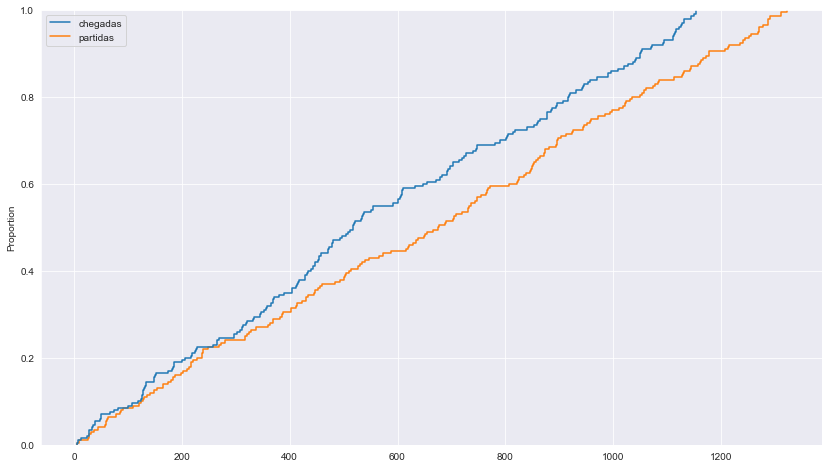

In [8]:
# Plota o gráfico
ax = sns.ecdfplot(data=[dados.chegadas, dados.partidas])
ax.figure.set_size_inches(14, 8)
ax

In [2]:
### Teste do uso da PyMC

import pymc3 as pm
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Gerando dados simulados para um modelo exponencial
np.random.seed(123)
dados = np.random.exponential(scale=0.08, size=200)     # usando mu = 0.08 e tamanho = 200

# Cria o modelo Bayesiano
with pm.Model() as model:
  # Priors para lambda e mu, ambos com dist. exponencial
  lambda_ = pm.Exponential("lambda_", 1)     # TODO: entender porque 1
  mu = pm.Exponential("mu", 1)               # TODO: entender porque 1

  # Dist. de probabilidade
  y = pm.Exponential("y", lambda_, observed=dados)

  # Inferência de MCMC -> preciso entender melhor esse sample
  trace = pm.sample(draws=2000, chains=2)

# Resultado da inferência
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, lambda_]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 43 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_,12.471,0.896,10.791,14.073,0.018,0.013,2450.0,1972.0,1.0
mu,1.025,1.024,0.001,2.901,0.020,0.015,1773.0,1240.0,1.0


In [9]:
def gera_amostras_priori():
    """
    Função de priori que gera amostras aleatórias de λ e μ a partir da distribuição a priori.
    :return: Os valores de lambda e mu, gerados a aprtir de uma distribuição exponencial de escala = 1.
    """
    lam = np.random.exponential(scale=1)
    mu = np.random.exponential(scale=1)
    return lam, mu

In [10]:
def distancia(dados_sim, dados_reais):
    """
    Função que calcula a distância Euclidiana entre os dados simulados e os dados reais.
    :param dados_sim: Os dados simulados.
    :param dados_reais: Os dados reais.
    :return: A diferença Euclidiana entre os dados simulados e reais.
    """
    return distance.euclidean(dados_sim, dados_reais)

In [11]:
def cria_fila_simulada(lambda_priori, mu_priori, num_servidores=2, tam_max_fila=200, seed=1914):
    """
    Função para gerar uma fila simulada com base nos parâmetros específicados.
    :param lambda_priori: O lambda definido a priori.
    :param mu_priori: O mu definido a priori.
    :param num_servidores: O número de servidores da fila. Padrão = 2.
    :param tam_max_fila: O tamanho máximo da fila. Padrão = 200.
    :param seed: A semente utilizada na geração dos dados aleatórios. Padrão = 1914.
    :return: Um dataframe, com os dados da fila gerada. O dataframe possuie as seguintes colunas: chegadas,
            tempo_servico, partidas, tempo_espera, atendente, tam_fila_chegada, tam_fila_partida
    """
    # Cria uma rede M/M/2 com os parâmetros definidos a priori
    N = ciw.create_network(
         arrival_distributions=[ciw.dists.Exponential(rate=lambda_priori)],
         service_distributions=[ciw.dists.Exponential(rate=mu_priori)],
         number_of_servers=[num_servidores]
    )

    # Define uma semente
    ciw.seed(seed)
    # Cria uma simulação
    Q = ciw.Simulation(N)
    # Roda a simulação até o máximo de clientes atendidos por dia (n = 200)
    Q.simulate_until_max_customers(tam_max_fila)

    # Pega os registros de atendimento e gera dataframe
    registros = Q.get_all_records()
    chegadas = []
    partidas = []
    tempo_servico = []
    tempo_espera = []
    atendente = []
    tam_fila_chegada = []
    tam_fila_partida = []

    for registro in registros:
         chegadas.append(registro.arrival_date)
         tempo_servico.append(registro.service_time)
         partidas.append(registro.exit_date)
         tempo_espera.append(registro.waiting_time)
         atendente.append(registro.server_id)
         tam_fila_chegada.append(registro.queue_size_at_arrival)
         tam_fila_partida.append(registro.queue_size_at_departure)

    dados = pd.DataFrame(np.stack((chegadas, tempo_servico, partidas, tempo_espera, atendente,
                                   tam_fila_chegada,tam_fila_partida), axis=-1),
                         columns=["chegadas", "tempo_servico", "partidas", "tempo_espera", "atendente",
                                  "tam_fila_chegada", "tam_fila_partida"])
    dados.sort_values("chegadas", inplace=True)

    return dados

In [23]:
# Define o array [tempo_medio_espera, tamanho_medio_fila] a partir da observação
valores_obs = [150, 22]     # tempo médio = 150 min, e tamanho_medio = 22 pessoas

tempo_inicial = time.time()

# Inicializa um dicionário vazio, que armazenadá os parâmetros (lambda e mu) e a distância para os dados reais
params_distancias = {}

# Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
for i in range(10000):
    # Gera amostras aleatórias de λ e μ a partir da distribuição a priori
    lam, mu = gera_amostras_priori()

    # Gera dados simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
    fila = cria_fila_simulada(lam, mu)

    # Os valores simulados para a fila gerada
    valores_sim = [fila.tempo_espera.mean(), fila.tam_fila_chegada.mean()]

    # Calcula a distância entre os dados simulados e os dados reais
    params_distancias[(lam, mu)] = distancia(valores_sim, valores_obs)

# Ordena, pelas distâncias, o dicionário que contém os parâmetros e as distâncias
params_dist_ordenados = sorted(params_distancias, key=params_distancias.get)

# recupera os 1% registros que tiveram as menores distâncias
amostras_posteriori = params_dist_ordenados[:int(len(params_dist_ordenados)*0.01)]
# Converte a lista de amostras a posteriori em um array NumPy
amostras_posteriori = np.array(amostras_posteriori)

tempo_final = time.time()

print('Tempo da simulação: ', (tempo_final-tempo_inicial))
print(amostras_posteriori)

Tempo da simulação:  260.4887261390686
[[0.23644458 0.08676154]
 [0.23423379 0.09227696]
 [0.13404005 0.06109483]
 [0.28489431 0.09588528]
 [0.26835045 0.09204751]
 [0.1694945  0.06832722]
 [0.30273612 0.10997025]
 [0.21595009 0.08415283]
 [0.17455937 0.06893595]
 [0.26599415 0.09209581]
 [0.2048006  0.07451573]
 [0.29065939 0.11337495]
 [0.26612606 0.07933731]
 [0.36381301 0.10715787]
 [0.40294455 0.13002814]
 [0.2247868  0.09504513]
 [0.42741975 0.14944643]
 [0.46666088 0.13823248]
 [0.23510909 0.08433116]
 [0.46427281 0.13677976]
 [0.48393879 0.12214658]
 [0.22286521 0.0842748 ]
 [0.27095684 0.1058037 ]
 [0.55245098 0.1410835 ]
 [0.23490279 0.09673437]
 [0.57318694 0.17175635]
 [0.50469492 0.17096514]
 [0.4180432  0.14113315]
 [0.25770756 0.09840533]
 [0.35515397 0.12476821]
 [0.59733559 0.14300212]
 [0.27130757 0.09650014]
 [0.39615184 0.13266268]
 [0.66435208 0.15762237]
 [0.56921147 0.15733942]
 [0.57955261 0.15210365]
 [0.60501508 0.14692668]
 [0.25976379 0.08975256]
 [0.6786425

In [24]:
# Extrai as amostras de λ e μ do array NumPy de amostras a posteriori
amostras_lambda = amostras_posteriori[:, 0]
amostras_mu = amostras_posteriori[:, 1]

# Imprime a média e o desvio padrão das amostras a posteriori de λ e μ
print(f'Lambda: média = {np.mean(amostras_lambda):.2f}, desvio padrão = {np.std(amostras_lambda):.2f}')
print(f'Mu: média = {np.mean(amostras_mu):.2f}, desvio padrão = {np.std(amostras_mu):.2f}')

Lambda: média = 0.52, desvio padrão = 0.23
Mu: média = 0.14, desvio padrão = 0.04


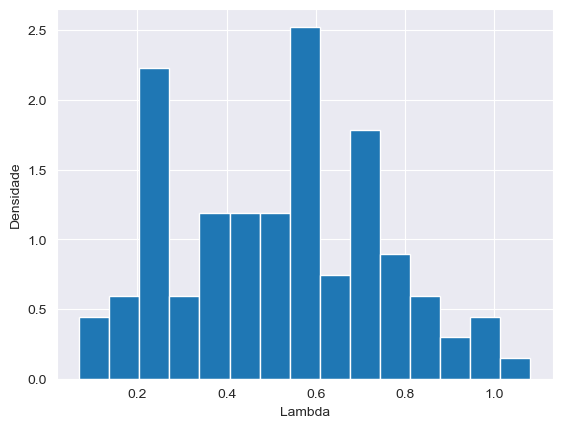

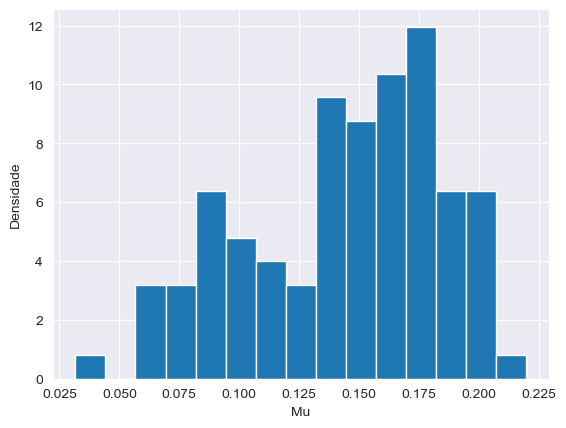

In [32]:
# Plota um histograma das amostras a posteriori de λ
plt.hist(amostras_lambda, bins=15, density=True)
plt.xlabel('Lambda')
plt.ylabel('Densidade')
plt.show()

# Plota um histograma das amostras a posteriori de μ
plt.hist(amostras_mu, bins=15, density=True)
plt.xlabel('Mu')
plt.ylabel('Densidade')
plt.show()